#Deep Convolutional Generative Adaptative Network DC-GAN

Some information about the project here

#Configuration

In [0]:
IMAGE_SIZE = 256
EPOCHS = 1000
NOISE_SIZE = 100
NUM_NEW_IMAGES = 0
DATASET_FOLDER = 'only_flowers/'
BATCH_SIZE = 64 # Simpsons
#BATCH_SIZE = 256 # TensowFlow tutorial

#LR_D = 0.001 # Default
#LR_D = 0.00004 # Simpsons
#LR_D = 0.00001 # TensoFlow tutorial
LR_D = 0.0002 # Paper

#LR_G = 0.001 # Default
#LR_G = 0.0004 # Simpsons
#LR_G = 0.0001 # TensorFlow tutorial
LR_G = 0.0002 # Paper

#BETA1 = 0.9 # Default
BETA1 = 0.5 # Simpsons and Paper

#EPSILON = 0.00005 # Simpsons
EPSILON = 0.001 # Default

#LEAK_RELU_APLPHA = 0.3 # Default
LEAK_RELU_APLPHA = 0.2 # Paper

KERNEL_INITIALIZER='glorot_uniform' # Default
#KERNEL_INITIALIZER='zeros' # Paper
#import tf.keras.initializers.TruncatedNormal
#KERNEL_INITIALIZER=tf.keras.initializers.TruncatedNormal(stddev=0.02) # Simpsons


#Imports

In [0]:
#!pip install imageio
#!pip install --user -U tensorflow==2.2.0rc2 tensorflow-gpu==2.2.0rc2
import tensorflow as tf
print(tf.__version__)

2.2.0-rc2


In [0]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Num GPUs Available:  1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [0]:
from datetime import datetime
import os
from glob import glob
from IPython import display
import imageio
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import PIL
from PIL import Image
import pytz
tz_NY = pytz.timezone('America/New_York') 
import random
from scipy import ndarray
import skimage as sk
from skimage import io
from skimage import util
from skimage import transform
import tensorflow as tf
from tensorflow.keras import layers
import time
import cv2


#Image presentation functions

In [0]:
def show_samples(sample_images):
    
    print("len(sample_images): ", len(sample_images))
    print("len(sample_images): ", sample_images[0].shape)
    
    figure, axes = plt.subplots(1, len(sample_images), figsize = (50, 50))

    print("figure: ", figure)
    print("axes: ", axes)

    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample_images[index]
        axis.imshow(image_array)
        
    plt.show()
    plt.close()

In [0]:
def show_image_custom(input_image):
    fig = plt.figure(figsize=(4,4))

    plt.imshow(input_image)

    plt.axis('off')

    plt.show()

In [0]:
def show_samples2(sample_images):
    figure, axes = plt.subplots(1, len(sample_images), figsize = (50, 50))

    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample_images[index]
        image_array = image_array.numpy() * 127.5 + 127.5
        axis.imshow(image_array.astype(np.uint8))

    plt.show()
    plt.close()

# Data Preparation

##Fetch the  Dataset

In [0]:
GET_DATASET = True
if GET_DATASET:
    print('Fechting the Image Data Set')
    !wget https://github.com/ravasconcelos/flowers_dcgan/raw/master/only_flowers.zip
    print('Unzipping the file')
    ZIP_FILE = 'only_flowers.zip'
    !unzip -q -o $ZIP_FILE
    print('Flower images are available')
#Check if there are some files in the folder
num_of_images = len(os.listdir(DATASET_FOLDER))
print('Number of images: ', num_of_images) 
for i in os.listdir(DATASET_FOLDER):
  image_file = cv2.imread(DATASET_FOLDER+i) # open colour image
  #image_file = image_file.convert('1') # convert image to black and white
  grayImage = cv2.cvtColor(image_file, cv2.COLOR_BGR2GRAY)
  cv2.imwrite( DATASET_FOLDER+i, grayImage );
  #image_file.save(DATASET_FOLDER+i)
#assert num_of_images == 249 

Fechting the Image Data Set
--2020-04-09 19:39:39--  https://github.com/ravasconcelos/flowers_dcgan/raw/master/only_flowers.zip
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ravasconcelos/flowers_dcgan/master/only_flowers.zip [following]
--2020-04-09 19:39:39--  https://raw.githubusercontent.com/ravasconcelos/flowers_dcgan/master/only_flowers.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10177417 (9.7M) [application/zip]
Saving to: ‘only_flowers.zip’

only_flowers.zip    100%[===================>]   9.71M  --.-KB/s    in 0.07s   

2020-04-09 19:39:40 (131 MB/s) - ‘only_flowers.zip’ saved [101

# Data Augmentation

Image transformation methods

In [0]:
def random_rotation(image_array: ndarray):
    # pick a random degree of rotation between 20% on the left and 20% on the right
    random_degree = random.uniform(-20, 20)
    return sk.transform.rotate(image_array, random_degree)

def horizontal_flip(image_array: ndarray):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, ::-1]

def vertical_flip(image_array: ndarray):
    return image_array[::-1, :]

def vertical_and_horizontal_flip(image_array: ndarray):
    h_flip_image = vertical_flip(image_array)
    return horizontal_flip(h_flip_image)

def rescale(image_array: ndarray):
    rescaled_image = sk.transform.rescale(image_array, 0.5, anti_aliasing=False)
    return sk.transform.resize(rescaled_image, (IMAGE_SIZE, IMAGE_SIZE))

def TF_crop_pad(x, n_pixels=20, pad_mode='edge'):
    """Pad image by n_pixels on each size, then take random crop of same
    original size.
    """
    assert len(x.shape) == 3
    h, w, nc = x.shape

    # First pad image by n_pixels on each side
    padded = sk.util.pad(x, [(n_pixels, n_pixels) for _ in range(2)] + [(0,0)],
        mode=pad_mode)

    # Then take a random crop of the original size
    crops = [(c, 2*n_pixels-c) for c in np.random.randint(0, 2*n_pixels+1, [2])]
    # For channel dimension don't do any cropping
    crops += [(0,0)]
    return sk.transform.resize(sk.util.crop(padded, crops, copy=True), (IMAGE_SIZE, IMAGE_SIZE))     



Create the new images doing random transformation on random images

In [0]:
def convert_gray2rgb(image):
    width, height = image.shape
    out = np.empty((width, height, 3), dtype=np.uint8)
    out[:, :, 0] = image
    out[:, :, 1] = image
    out[:, :, 2] = image
    return out

In [0]:
# dictionary of the transformations we defined earlier
available_transformations = {
    'rotate': random_rotation,
    'vertical_flip': vertical_flip,
    'horizontal_flip': horizontal_flip,
    'vertical_and_horizontal_flip': vertical_and_horizontal_flip,
    #'TF_crop_pad': TF_crop_pad
}

folder_path = DATASET_FOLDER

# find all files paths from the folder
images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

num_generated_files = 0
while num_generated_files <= NUM_NEW_IMAGES:
    # random image from the folder
    image_path = random.choice(images)
    # read image as an two dimensional array of pixels
    image_to_transform = sk.io.imread(image_path)
    #image_to_transform = convert_gray2rgb(image_to_transform)
    # random num of transformation to apply
    num_transformations_to_apply = random.randint(1, len(available_transformations))
    num_transformations = 0
    transformed_image = None
    while num_transformations <= num_transformations_to_apply:
        # random transformation to apply for a single image
        key = random.choice(list(available_transformations))
        transformed_image = available_transformations[key](image_to_transform)
        num_transformations += 1

        new_file_path = '%s/augmented_image_%s.jpg' % (folder_path, num_generated_files)

        # write image to the disk
        #io.imsave(new_file_path, transformed_image.astype(np.uint8))
        io.imsave(new_file_path, transformed_image)
        num_generated_files += 1


In [0]:
np.atleast_3d(image_to_transform).shape

(333, 500, 1)

In [0]:
for file in glob(DATASET_FOLDER+'*'):
  a=np.asarray([np.asarray(Image.open(file).resize((IMAGE_SIZE, IMAGE_SIZE))])
print(a.shape) 

### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

Input: (251, 256, 256)
len(sample_images):  5
len(sample_images):  (256, 256)
figure:  Figure(3600x3600)
axes:  [<matplotlib.axes._subplots.AxesSubplot object at 0x7f3bee9b46d8>


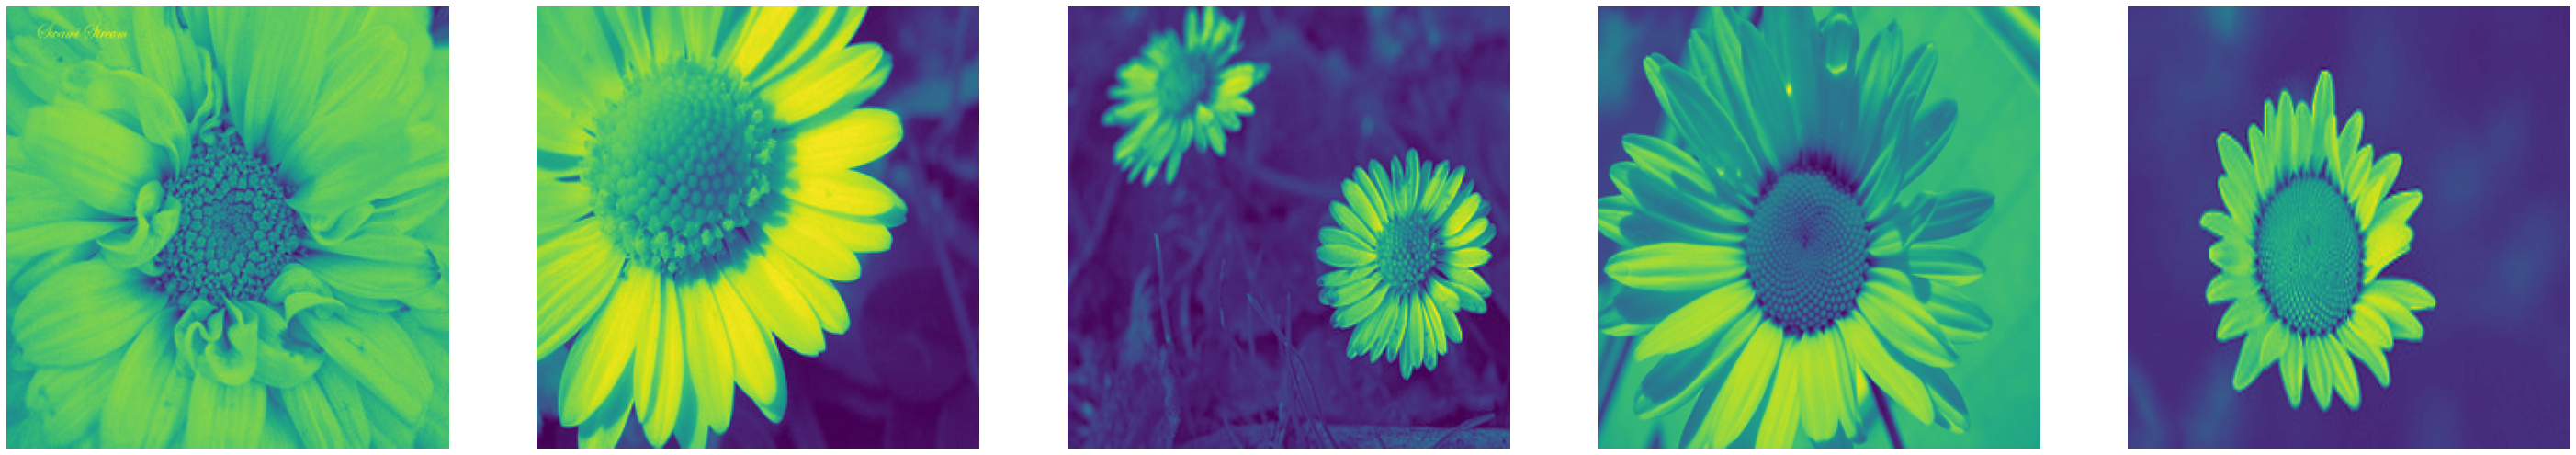

In [0]:
input_images = np.asarray([np.asarray(Image.open(file).resize((IMAGE_SIZE, IMAGE_SIZE))) for file in glob(DATASET_FOLDER+'*')])
print ("Input: " + str(input_images.shape))

np.random.shuffle(input_images)
sample_images = input_images[:5]
show_samples(sample_images)


In [0]:
input_images.shape
len(input_images)

254

In [0]:
input_images.shape

(254, 256, 256, 3)

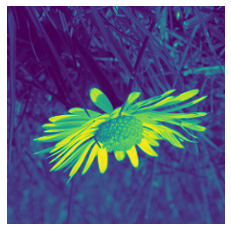

In [0]:
show_image_custom(vertical_flip(input_images[0]))

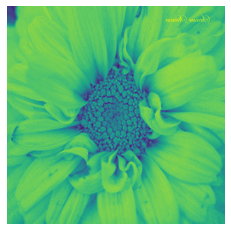

In [0]:
show_image_custom(horizontal_flip(input_images[0]))

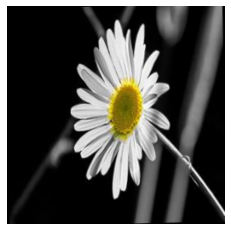

In [0]:
show_image_custom(random_rotation(input_images[0]))

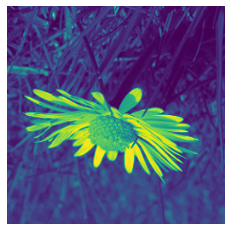

In [0]:
show_image_custom(vertical_and_horizontal_flip(input_images[0]))

In [0]:
train_images = input_images.reshape(input_images.shape[0], 256, 256, 1).astype('float32')
ha_img=input_images
ha_img.resize(255,256,256,3,refcheck=False)
train_images.resize(255,256,256,3,refcheck=False)
train_images = (train_images - 127.5) / 127.5 

ValueError: ignored

In [0]:
train_images.shape

(255, 256, 256, 3)

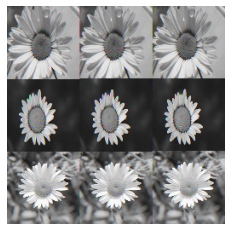

In [0]:
train_images2 = (train_images * 127.5) + 127.5

fig = plt.figure(figsize=(4,4))

plt.imshow(train_images2[1].astype(np.uint8) )

plt.axis('off')

plt.show()


In [0]:

np.atleast_3d(train_images).shape

In [0]:
g = train_images
g.resize(255,256,256,3,refcheck=False)
g.shape

In [0]:
BUFFER_SIZE = input_images.shape[0]

In [0]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 256x256x3. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(64*64*256, use_bias=False, input_shape=(NOISE_SIZE,)))
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.ReLU())

    model.add(layers.Reshape((64, 64, 256)))
    assert model.output_shape == (None, 64, 64, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False,
                                    kernel_initializer=KERNEL_INITIALIZER))
    assert model.output_shape == (None, 64, 64, 128)
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False,
                                    kernel_initializer=KERNEL_INITIALIZER))
    assert model.output_shape == (None, 128, 128, 64)
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh',
                                    kernel_initializer=KERNEL_INITIALIZER))
    assert model.output_shape == (None, 256, 256, 3)

    return model

Use the (as yet untrained) generator to create an image.

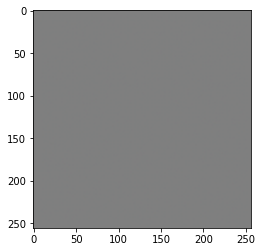

In [0]:
generator = make_generator_model()

noise = tf.random.normal([1, NOISE_SIZE])
generated_image = generator(noise, training=False)

generated_image2 = generated_image[0].numpy() * 127.5 + 127.5

plt.imshow(generated_image2.astype('uint8'))

### The Discriminator

The discriminator is a CNN-based image classifier.

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[256, 256, 3],
                                    kernel_initializer=KERNEL_INITIALIZER))
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.LeakyReLU(alpha=LEAK_RELU_APLPHA))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same',
                                    kernel_initializer=KERNEL_INITIALIZER))
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.LeakyReLU(alpha=LEAK_RELU_APLPHA))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [0]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-7.527182e-05]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [0]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [0]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=LR_D, beta_1=BETA1)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=LR_G, beta_1=BETA1)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [0]:

noise_dim = NOISE_SIZE
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
def summarize_epoch(epoch, d_losses, g_losses, save_image=True):
  
    fig, ax = plt.subplots()
    plt.plot(d_losses, label='Discriminator', alpha=0.6)
    plt.plot(g_losses, label='Generator', alpha=0.6)
    plt.title("Losses")
    plt.legend()
    if save_image:
        plt.savefig("losses_" + str(epoch) + ".png")
    plt.show()
    plt.close()
    

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [0]:
def train(dataset, epochs):
  print('Training started at: ', datetime.now(tz_NY))
  save_image = False
  d_losses = []
  g_losses = []
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      d_loss, g_loss = train_step(image_batch)
      d_losses.append(d_loss)
      g_losses.append(g_loss)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    

    # Save the model every 15 epochs
    if (epoch + 1) % 500 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
      save_image = True

    generate_and_save_images(generator,
                             epoch + 1,
                             seed,
                             save_image)
    summarize_epoch(epoch, d_losses, g_losses, save_image)
    save_image = False
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
9
  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  summarize_epoch(epoch, d_losses, g_losses)

  

**Generate and save images**


In [0]:
def generate_and_save_images(model, epoch, test_input, save_image=True):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      generated_image2 = predictions[i].numpy() * 127.5 + 127.5
      plt.imshow(generated_image2.astype('uint8'))

      plt.axis('off')

  if save_image:
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

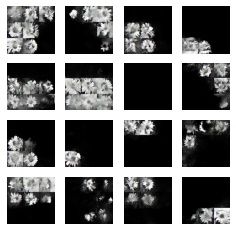

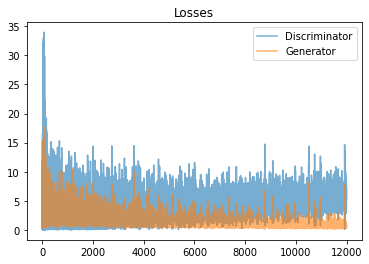

In [0]:
train(train_dataset, 3000)

In [0]:
checkpoint.save(file_prefix = checkpoint_prefix)

'./training_checkpoints/ckpt-8'

In [0]:
train(train_dataset, 900)

noise = tf.random.normal([5, NOISE_SIZE])
generated_image = generator(noise, training=False)
show_samples2(generated_image)


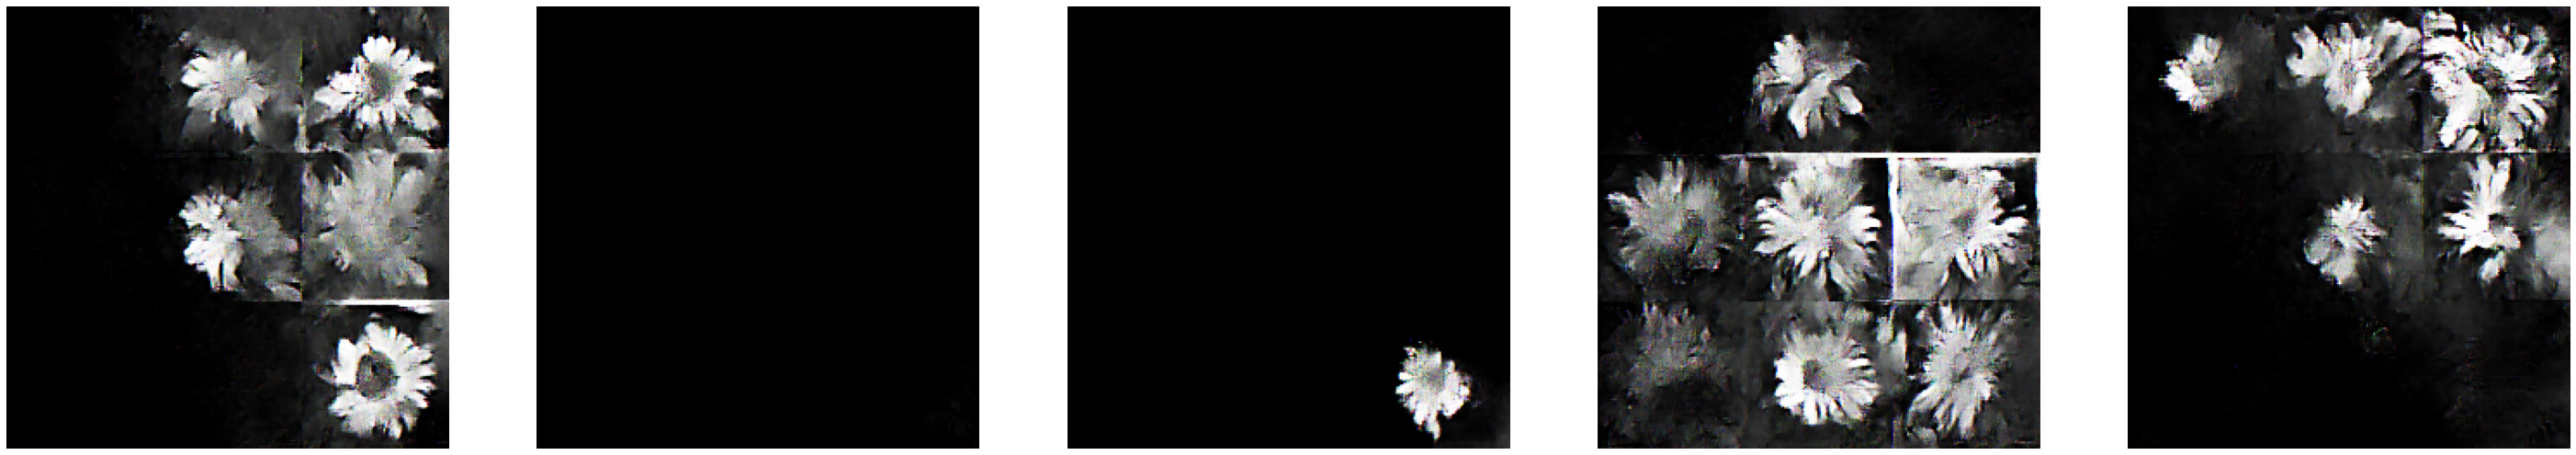

In [0]:
noise = tf.random.normal([5, NOISE_SIZE])
generated_image = generator(noise, training=False)
show_samples2(generated_image)

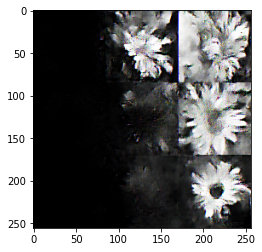

In [0]:
noise = tf.random.normal([1, NOISE_SIZE])
generated_image = generator(noise, training=False)
generated_image2 = generated_image[0].numpy() * 127.5 + 127.5

plt.imshow(generated_image2.astype(np.uint8))
plt.show()
plt.close()

In [0]:
CHKP_INDEX = '2'
def download_checkpoint():
    try:
        from google.colab import files
    except ImportError:
        pass
    else:
        files.download('training_checkpoints/ckpt-'+CHKP_INDEX+'.data-00000-of-00002')
        files.download('training_checkpoints/ckpt-'+CHKP_INDEX+'.data-00001-of-00002')
        files.download('training_checkpoints/ckpt-'+CHKP_INDEX+'.index')
        files.download('training_checkpoints/checkpoint')

if CHKP_INDEX != '':
    download_checkpoint()

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 42242, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil



```
# This is formatted as code
```

To restore a checkpoint upload a the ckpt files into training_checkpoints folder.

In [0]:
#!zip training_checkpoints/* checkpoint.zip
!ls -la training_checkpoints/

In [0]:
#!unzip training_checkpoints/ckpt-3.zip
#!ls -ls training_checkpoints/
#!pip install tensorflow==2.1
import tensorflow as tf
tf.__version__

In [0]:
# upload the files (checkpoint, ckpt-xxx.index, ckpt-xxx.data-*) into training_checkpoints folder
RESTORE_CHECKPOINT = True
if RESTORE_CHECKPOINT:
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [0]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [0]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [0]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

If you're working in Colab you can download the animation with the code below:

In [0]:
DOWNLOAD = False
if DOWNLOAD:
    try:
        from google.colab import files
    except ImportError:
        pass
    else:
        files.download(anim_file)

# More information about GAN


To learn more about GANs we recommend the [NIPS 2016 Tutorial: Generative Adversarial Networks](https://arxiv.org/abs/1701.00160).


#Clean up

In [0]:
if True:
    !rm losses_*
    !rm image_*
    #!rm only_flowers/au*
    !rm -r only_flowers/
    !rm only_flowers.zip*
    !rm -r __MACOSX/
    !rm dcgan.gif
    !rm -r training_checkpoints/
    #!ls -la training_checkpoints/*